In [3]:
from tqdm.auto import trange
import numpy as np
import cupy as cp
import pathlib
import sys

In [4]:
sys.path.append(str(pathlib.Path('../').resolve()))

In [5]:
from lib.utils.data import Dataset, shuffle_dataset, load_integer_dataset
from lib.utils.enums import Initialization, NonLinearity, OptimizerName
from lib.utils.nn import accuracy, plot_history, l2_loss
from lib.experiments import build_augmentation_pipeline
from lib.utils.train import train_step_local, val_step
from lib.utils.misc import to_cpu

# Experiment config

In [6]:
architecture = [
    ('Conv2d', 64, 11, 1, 2),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 192, 5, 1, 2),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 384, 3, 1, 1),
    ('Conv2d', 256, 3, 1, 1),
    ('Conv2d', 256, 3, 1, 1),
    ('MaxPool2d', 2, 2)
]
num_fc_layers = 2
num_fc_hidden = [1024]

In [7]:
dataset_config = dict(
    dataset=Dataset.CIFAR10.name,
    subsample_ratio=0.5,
    ohe_values=(0, 32),
    add_padding=False,
    normalize=True,
    data_augmentation=True,
)

In [8]:
network_config = dict(
    num_fc_layers=num_fc_layers,
    num_fc_hidden=num_fc_hidden,
    non_linearity=NonLinearity.NITRO_LEAKY_RELU.name,
    init=Initialization.UNIFORM_KAIMING_LEAKY_RELU.name,
    dtype='int32',
    device='cuda',
    local_loss='pred',
    pred_decoder_dim=4096,
    fe_dropout_rate=0.0,
    fc_dropout_rate=0.25,
    seed=42,
    bias=False,
    debug=False,
)

In [9]:
training_config = dict(
    batch_size=64,
    num_epochs=35,
    lr_inv=512,
    lr_amp_factor=None,
    fwd_decay_inv=15_000,
    subnet_decay_inv=1_000,
    optimizer=OptimizerName.INTEGER_SGD.name,
)

In [10]:
config = dataset_config | network_config | training_config

In [11]:
# Setup reproducibility
np.random.seed(config["seed"])
cp.random.seed(config["seed"])

# Data

Files already downloaded and verified
Files already downloaded and verified
Subsampling applied: training on 20000 samples
Data normalized. New statistics:
-  Min: [-123 -123 -105]
-  Max: [126 127 127]
- Mean: [0 0 0]
-  Std: [61 62 61]

Moved data to device: <CUDA Device 0>
Train set:  (20000, 3, 32, 32), (20000, 10)
Val set:    (10000, 3, 32, 32), (10000, 10)
Test set:   (10000, 3, 32, 32), (10000, 10)
Data types: (int8, int8)


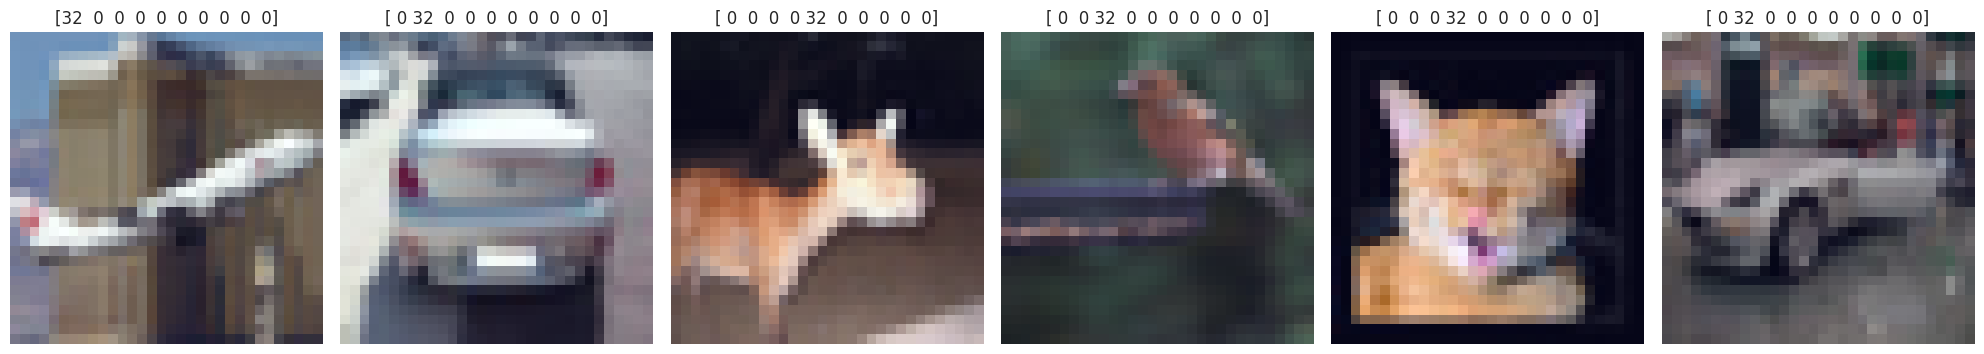

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = load_integer_dataset(config, add_padding=False, ohe_values=(0, 32))

In [13]:
# Configure data augmentation
augmentation_pipeline = build_augmentation_pipeline(config)
print(augmentation_pipeline)

AugmentationPipeline([
    RandomCrop(size=32, padding=4, probability=0.5)
    RandomHorizontalFlip(probability=0.5)
])


# Network

In [14]:
from lib.models.local_loss_models import IntegerLocalLossCNN

In [15]:
model = IntegerLocalLossCNN(
    fe_architecture=architecture,
    input_channels=X_train.shape[1],
    image_size=X_train.shape[2],
    num_fc_layers=config['num_fc_layers'],
    num_hidden_fc=config['num_fc_hidden'],
    num_classes=y_train.shape[1],
    local_loss=config['local_loss'],
    fe_dropout_rate=config['fe_dropout_rate'],
    fc_dropout_rate=config['fc_dropout_rate'],
    pred_decoder_dim=config['pred_decoder_dim'],
    fwd_decay_inv=config['fwd_decay_inv'],
    subnet_decay_inv=config['subnet_decay_inv'],
    device=config['device'],
    non_linearity=NonLinearity[config['non_linearity']],
    init=Initialization[config['init']],
    optimizer=OptimizerName[config['optimizer']],
    dtype=config['dtype'],
    bias=config['bias'],
    debug=config['debug'],
    lr_amp_factor=config['lr_amp_factor']
)
print(model.extra_repr(1))

IntegerLocalLossCNN(
	(0): Sequential(
			(0): LocalConv2dBlock(
			(0): IntegerConv2d(in_channels=3, out_channels=64, bias=False, decay_rate_inv=15000)
			(1): ConstantScaling(fwd_factor=92928, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=(2, 2))
			(1): Flatten()
			(2): IntegerLinear(in_features=3136, out_features=10, bias=False, decay_rate_inv=1000)
			(3): ConstantScaling(fwd_factor=802816, bwd_factor=1)
		)
	)
			(1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
			(2): LocalConv2dBlock(
			(0): IntegerConv2d(in_channels=64, out_channels=192, bias=False, decay_rate_inv=15000)
			(1): ConstantScaling(fwd_factor=409600, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=(2, 2))
			(1): Flatten()
			(2): IntegerLinear(in_features=3072, out_features=10, bias=F

In [16]:
model.print_layers_parameters()

Layer: conv_encoder_00
- Weights:
[[[[  1  -3   5 ...   2  -4   8]
   [-10  10 -11 ...  13  -2   7]
   [  9  -7   5 ...  -5 -13  -7]
   ...
   [  8  16 -16 ...  -3   4   4]
   [  0 -13   6 ...   4  -6 -16]
   [ -2 -16 -14 ... -16  11   5]]

  [[  4  13  10 ... -10  -5 -15]
   [ 15  14   2 ... -13 -16  15]
   [ -8   8  10 ...  15 -12 -16]
   ...
   [ 11  11   8 ...   1   9  -8]
   [ 15  -2  15 ...   5  15  15]
   [-12  -8  -9 ...  -3  -7  -2]]

  [[ -3 -14  -8 ...  12 -11   7]
   [-11   7   0 ...   0  -5   9]
   [ 14  -7  -3 ...  15  -9 -13]
   ...
   [  2  16  -8 ...   8   0   8]
   [ 10   1 -12 ...  -4   4  10]
   [ 11  -2 -10 ...   4  -6   2]]]


 [[[  3   4  -2 ...   8  12   9]
   [  8 -14   2 ...  -6  12  -3]
   [-10   2   6 ... -12  15   4]
   ...
   [  9  -9  11 ...  -1  -5 -16]
   [-16   2   6 ...  13  -5  10]
   [ -8 -15  -5 ...  -8  -3 -13]]

  [[ 14   8  16 ...  -3  14   8]
   [  9  -4 -14 ...   6   0  15]
   [ -4   3 -11 ...  14  14 -15]
   ...
   [  9 -16  16 ...  -7   3   

# Training

In [17]:
from lib.optim.lr_schedulers import ConstantLR
from lib.utils.nn import EarlyStopping, ReduceLROnPlateau

In [18]:
lr_scheduler = ConstantLR(config['lr_inv'])
early_stopping = EarlyStopping(min_delta=0.01, patience=25, from_epoch=10)
reduce_lr_plateau = ReduceLROnPlateau(factor=2, min_delta=0.01, patience=15, from_epoch=10)

In [19]:
n_train_batches = len(X_train) // config['batch_size']
n_val_batches = len(X_val) // config['batch_size']
last_epoch = 0

xp = cp.get_array_module(X_train)
loss_history = xp.empty(config['num_epochs'])
acc_history = xp.empty(config['num_epochs'])
val_loss_history = xp.empty(config['num_epochs'])
val_acc_history = xp.empty(config['num_epochs'])

for epoch in trange(config['num_epochs']):
    # Train and validation loops
    lr_scheduler.step()
    X_train, y_train = shuffle_dataset(X_train, y_train)
    
    loss_history[epoch], acc_history[epoch], local_losses, local_accuracies = train_step_local(
        model=model,
        X_train=X_train,
        y_train=y_train,
        batch_size=config['batch_size'],
        n_train_batches=n_train_batches,
        augmentation_pipeline=augmentation_pipeline,
        lr_inv=lr_scheduler.get_lr()
    )
    
    val_loss_history[epoch], val_acc_history[epoch] = val_step(
        model=model, 
        X_val=X_val, 
        y_val=y_val, 
        batch_size=config['batch_size'], 
        n_val_batches=n_val_batches
    )
    
    last_epoch = epoch

    if epoch % 3 == 0:
        print(f"Epoch {epoch}:")
        for i, (local_loss, local_acc) in enumerate(zip(local_losses, local_accuracies)):
            print(f"- Local accuracy {i}: {local_acc:.2%}")
        print(f"- Output accuracy: {acc_history[epoch]:.2%}")
        print(f"- Output val accuracy: {val_acc_history[epoch]:.2%}")
        print("\n")

    # Early stopping
        if early_stopping.early_stop(float(val_acc_history[epoch])):
            print(f"{'-' * 64}\nEarly stopping at epoch {epoch + 1}\n{'-' * 64}")
            break

    # ReduceLROnPlateau
    if reduce_lr_plateau.reduce_lr(float(val_acc_history[epoch])):
        lr_scheduler.set_lr(lr_scheduler.get_lr() * reduce_lr_plateau.factor)
        print(f"{'-' * 64}\nReducing learning rate on plateau at epoch {epoch + 1}\n{'-' * 64}")
    
print(f'Final train loss: {loss_history[last_epoch]:.5f}')
print(f'Final train accuracy: {acc_history[last_epoch]:.2%}')
print(f'Final validation loss: {val_loss_history[last_epoch]:.5f}')
print(f'Final validation accuracy: {val_acc_history[last_epoch]:.2%}')

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 0:
- Local accuracy 0: 27.88%
- Local accuracy 1: 9.51%
- Local accuracy 2: 9.70%
- Local accuracy 3: 9.86%
- Local accuracy 4: 9.52%
- Local accuracy 5: 14.98%
- Output accuracy: 9.92%
- Output val accuracy: 9.66%


Epoch 3:
- Local accuracy 0: 47.54%
- Local accuracy 1: 39.50%
- Local accuracy 2: 36.84%
- Local accuracy 3: 34.44%
- Local accuracy 4: 32.64%
- Local accuracy 5: 20.37%
- Output accuracy: 13.96%
- Output val accuracy: 22.12%


Epoch 6:
- Local accuracy 0: 51.64%
- Local accuracy 1: 47.69%
- Local accuracy 2: 45.07%
- Local accuracy 3: 42.55%
- Local accuracy 4: 41.14%
- Local accuracy 5: 39.06%
- Output accuracy: 34.01%
- Output val accuracy: 39.71%


Epoch 9:
- Local accuracy 0: 53.55%
- Local accuracy 1: 52.32%
- Local accuracy 2: 50.67%
- Local accuracy 3: 48.79%
- Local accuracy 4: 47.33%
- Local accuracy 5: 47.35%
- Output accuracy: 44.62%
- Output val accuracy: 44.79%


Epoch 12:
- Local accuracy 0: 55.15%
- Local accuracy 1: 55.20%
- Local accuracy 2: 54.27%

In [20]:
y_subnets = model.subnetworks_predict(X_test)
for i, y_subnet in enumerate(y_subnets):
    subnet_acc = accuracy(y_test, y_subnet)
    print(f'Local Val Accuracy {i}: {subnet_acc:.2%}')

Local Val Accuracy 0: 61.20%
Local Val Accuracy 1: 65.54%
Local Val Accuracy 2: 66.69%
Local Val Accuracy 3: 66.09%
Local Val Accuracy 4: 64.94%
Local Val Accuracy 5: 65.23%


In [21]:
loss_history, val_loss_history  = loss_history[:last_epoch+1], val_loss_history[:last_epoch+1]
acc_history, val_acc_history = acc_history[:last_epoch+1], val_acc_history[:last_epoch+1]

if config['device'] == 'cuda':
    # Move training statistics to the CPU
    loss_history, val_loss_history = to_cpu(loss_history), to_cpu(val_loss_history)
    acc_history, val_acc_history = to_cpu(acc_history), to_cpu(val_acc_history)

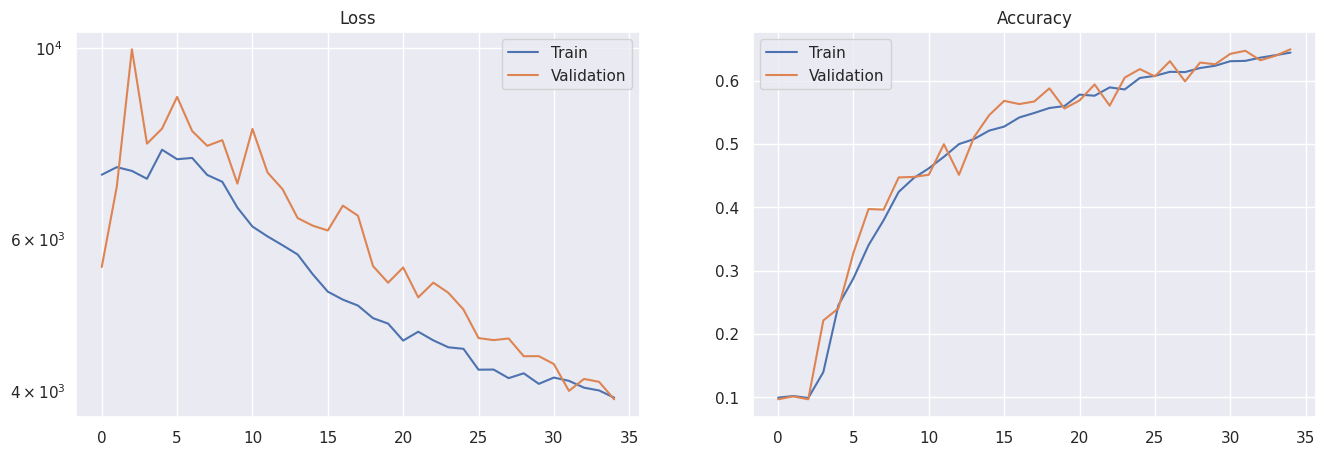

In [22]:
plot_history(loss_history, val_loss_history, acc_history, val_acc_history, log_scale=True)

In [23]:
y_pred = model.predict(X_test, progress_bar=False)
test_loss = l2_loss(y_test, y_pred)
test_acc = accuracy(y_test, y_pred)
print(f'Test accuracy: {test_acc:.2%}')

Test accuracy: 65.19%
